<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier , RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing  import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### ✅1. 전처리 규칙
    * 파생변수 ind11칼럼의 값이 1인 데이터만 훈련에 사용할 것, ind22칼럼의 값이 1인 데이터만 테스트에 사용할 것
    * 모든 모델링은 그리드서치를 통해서 최적 파라미터를 산출할 것 (각 모델의 파라미터는 3개 이하로

#### ✅1.1 date 컬럼을 이용하여 3개의 파생변수
    month : 해당 시각의 월 정보
    day : 해당 시각의 일자 정보, 일요일-0, 월요일-1 ~ 토요일-6
    nsd : 해당 시각의 일자의 자정으로부터 소요된 총 분(minute

In [4]:
df = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_32회/data/32/adp32_p1.csv",index_col=0)
df.head(5)

,Kwh,LaCR,LeCR,co2,LaF,LeF
date,,,,,,
01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0
01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0
01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0
01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0
01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0


In [5]:
df1 = df.reset_index()

df1['date'] = pd.to_datetime(df1['date'], format = '%d/%m/%Y %H:%M')
#month : 해당 시각의 월 정보
df1['month'] = df1['date'].dt.month

#day : 해당 시각의 일자 정보, 일요일-0, 월요일-1 ~ 토요일-6
# day of week
df1['day']= (df1['date'].dt.day_of_week + 1) % 7
#nsd : 해당 시각의 일자의 자정으로부터 소요된 총 분(minute)
df1['nsd'] = df1['date'].dt.minute + df1['date'].dt.hour * 60

#### ✅1.2 두개의 파생변수를 추가

    파생변수명(ind11) : month, day, nsd 컬럼의 합이 11의 배수이고 22의 배수가 아니라면 1의 값 그 외는 0의 값
    파생변수명(ind22) : month, day, nsd 컬럼의 합이 22의 배수라면 1의 값 그 외는 0의 값

In [6]:
df1['ind11'] = df1.apply(lambda x : 1 if
                                     ((x['month'] + x['day'] + x['nsd'] )% 11 == 0 ) &
                                     ((x['month'] + x['day'] + x['nsd'] )% 22 != 0 ) else 0 , axis =1)


df1['ind22'] = df1.apply(lambda x : 1 if
                                      ((x['month'] + x['day'] + x['nsd'] )% 22 == 0 ) else 0 , axis =1)

#### ✅1.3 파생변수명(Kwh8) : Kwh컬럼의 값이 4.1 초과일 경우 1 그 외 0

In [7]:
df1['Kwh8'] = df1['Kwh'].apply(lambda x : 1 if x > 4.1 else 0)

#### ✅ 1-4 전처리 완료한 데이터를 기준으로 EDA를 실시

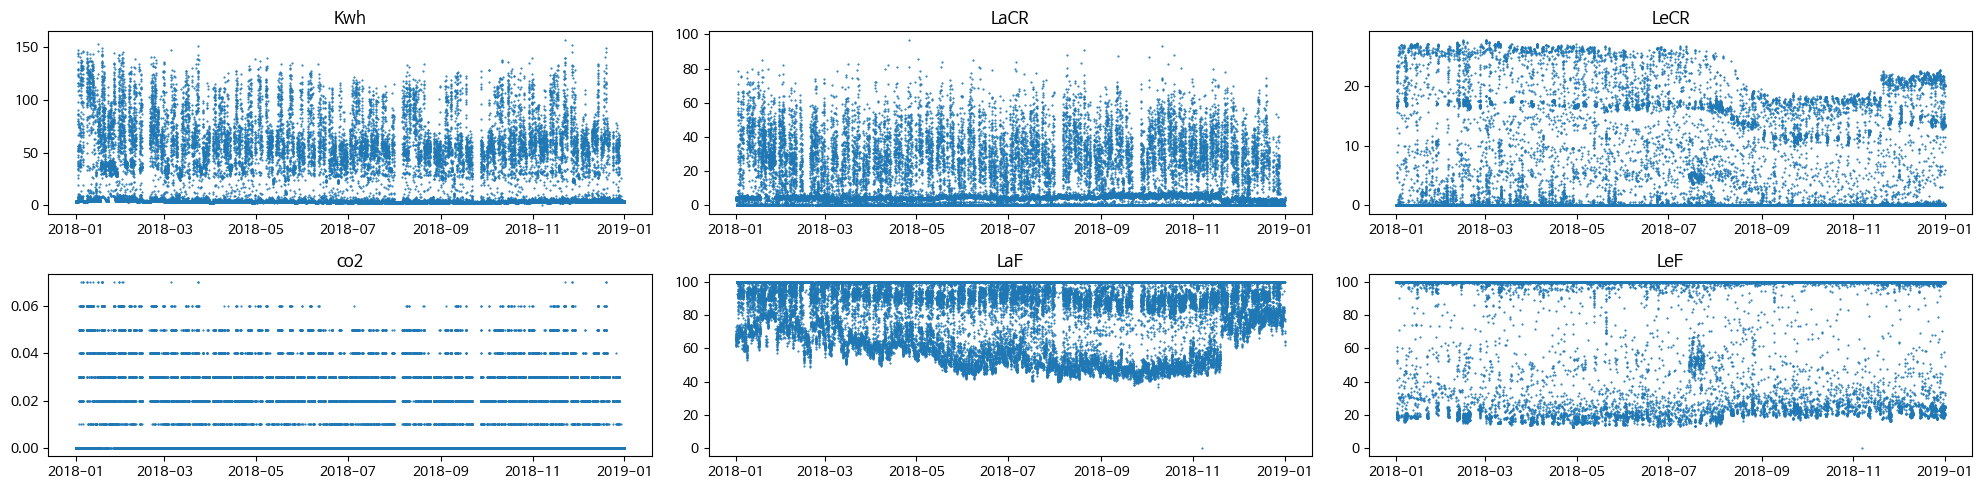

In [8]:
# 통계량 - 날짜 기준
fig,axes = plt.subplots(2,3,figsize=(20,5))

for i,ax in enumerate(axes.flat):
    target_df = df1[['date',df1.columns[1:][i]]]
    ax.scatter(x = target_df['date'],y= target_df[df1.columns[1:][i]],s=0.3)
    ax.set_title(df1.columns[1:][i])

fig.tight_layout()
plt.show()

#### ✅ 1-5  Kwh8를 종속 변수로 하여(Kwh제거) 분류 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용하라. confusionmatrix를 해석

    1) 파생변수 ind11칼럼의 값이 1인 데이터만 훈련에 사용할 것, ind22칼럼의 값이 1인 데이터만 테스트에 사용할 것
    2) 모든 모델링은 그리드서치를 통해서 최적 파라미터를 산출할 것

In [9]:
r_df = df1.drop(columns = ['date'], axis = 1)

# Train
train_set = r_df[r_df['ind11'] == 1]
x_train = train_set.drop(columns = ['Kwh8' ,'Kwh'])

# Scaler
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns = x_train.columns)

y_train = train_set['Kwh8']

# Test
test_set = r_df[r_df['ind22'] == 1]
x_test = test_set.drop(columns = ['Kwh8' ,'Kwh'])
x_test = pd.DataFrame(ss.fit_transform(x_test), columns = x_test.columns)
y_test = test_set['Kwh8']

{'C': 2.0, 'degree': 3, 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       729
           1       0.98      0.88      0.92       854

    accuracy                           0.92      1583
   macro avg       0.92      0.93      0.92      1583
weighted avg       0.93      0.92      0.92      1583



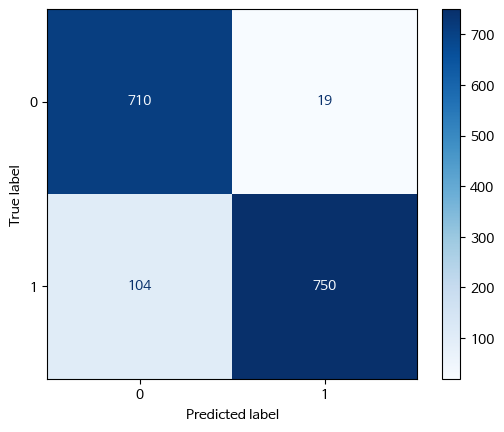


SVC 모델은 마진 최대화 원리를 기반으로 하여, 데이터간 경계가 명확할 경우 우수한 분류 성능을 보인다.
커널 트릭 (rf, linear)가 있기 때문에 비선형 데이터를 선형적으로 구분 할 수 있다.

1. precision (정밀도) - 예측한 것들 중에 실제인 것들을 나타내며, 1을 0.98로 정확하게 탐지했다
2. recall(재현율) - 실제 데이터인것을 중에, 모델이 올바르게 예측한 비율을 나타낸다
3. F1-score : 정밀도, 재현율의 조화평균으로 두 지표의 균형을 확인하기 위한 수치이다.

표 해석
TN  FP
FN  TP 의 순서로
FN이 104로 실제 1인데 0으로 예측한 수가 많다. 즉, 1을 0으로 잘못 예측하느 경우가 더 많다는 것을 말한다.

정밀도, 재현율, F1-scored가 97&로 높아 모델 성능이 좋은 편이나, FN(104)가 FP(19)보다 높은 것으로 보아
1 인 것들을 놓치는 것들에 대한 모델의 한계가 있다고 보여진다.



In [10]:
## SCV
from sklearn.metrics import ConfusionMatrixDisplay
scv = SVC()

param = {
    'C': [0.1,1,1.5, 2.0] ,
    'kernel': ["rbf","linear"],
    'degree': [3,4,5,6]
}

scv_grid = GridSearchCV(scv, param, cv = 5,  refit = True )

scv_grid.fit(x_train, y_train)
print(scv_grid.best_params_)

best_ = scv_grid.best_estimator_
best_.fit(x_train, y_train)
scv_pred = best_.predict(x_test)

print(classification_report(y_test, scv_pred))

cm = confusion_matrix(y_test, scv_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('''
SVC 모델은 마진 최대화 원리를 기반으로 하여, 데이터간 경계가 명확할 경우 우수한 분류 성능을 보인다.
커널 트릭 (rf, linear)가 있기 때문에 비선형 데이터를 선형적으로 구분 할 수 있다.

1. precision (정밀도) - 예측한 것들 중에 실제인 것들을 나타내며, 1을 0.98로 정확하게 탐지했다
2. recall(재현율) - 실제 데이터인것을 중에, 모델이 올바르게 예측한 비율을 나타낸다
3. F1-score : 정밀도, 재현율의 조화평균으로 두 지표의 균형을 확인하기 위한 수치이다.

표 해석
TN  FP
FN  TP 의 순서로
FN이 104로 실제 1인데 0으로 예측한 수가 많다. 즉, 1을 0으로 잘못 예측하느 경우가 더 많다는 것을 말한다.

정밀도, 재현율, F1-scored가 97&로 높아 모델 성능이 좋은 편이나, FN(104)가 FP(19)보다 높은 것으로 보아
1 인 것들을 놓치는 것들에 대한 모델의 한계가 있다고 보여진다.
''')

{'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 5}
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       729
           1       0.94      0.94      0.94       854

    accuracy                           0.93      1583
   macro avg       0.93      0.93      0.93      1583
weighted avg       0.93      0.93      0.93      1583



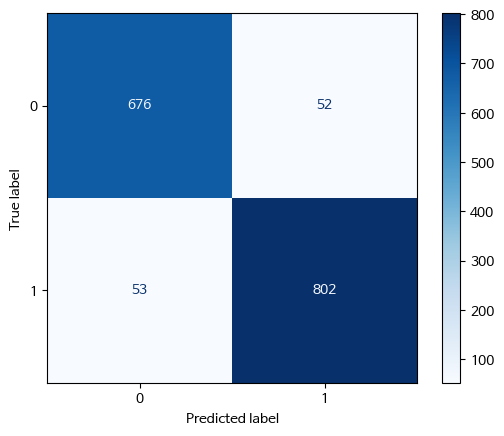


혼동 행렬 분석 결과
  TN  FP
  FN  TP

FN : 실제 1인경우를 0으로 예측한 수 57, FP : 실제 0인것을 1로 예측한 54건으로
정밀도와 재현율이 0과 1 각각 비슷한 수준으로 나왔다.
모델의 정확도는 서포트 벡터 머신 보다 높은 것으로 확인된다.



In [11]:
## Random_Forest
import warnings
warnings.filterwarnings('ignore')

rf = RandomForestClassifier( )

param = {
    'n_estimators': range(1,10) ,
    'max_depth': range(1,10),
    'min_samples_split': range(1,10)
}

rf_grid = GridSearchCV(rf, param, cv = 5,  refit = True )

rf_grid.fit(x_train, y_train)
print(rf_grid.best_params_)

best_ = rf_grid.best_estimator_
best_.fit(x_train, y_train)
rf_pred = best_.predict(x_test)

print(classification_report(y_test, rf_pred))

cm = confusion_matrix(rf_pred, y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('''
혼동 행렬 분석 결과
  TN  FP
  FN  TP

FN : 실제 1인경우를 0으로 예측한 수 57, FP : 실제 0인것을 1로 예측한 54건으로
정밀도와 재현율이 0과 1 각각 비슷한 수준으로 나왔다.
모델의 정확도는 서포트 벡터 머신 보다 높은 것으로 확인된다.
''')

#### ✅ 1-6 Kwh를 종속 변수로 하여(Kwh8 제거) 회귀 모델을 학습하고 평가하라. 서포트벡터머신과 랜덤포레스트를 사용

In [12]:
r_df = df1.drop(columns = ['date'], axis = 1)

# Train
train_set = r_df[r_df['ind11'] == 1]
x_train = train_set.drop(columns = ['Kwh8' ,'Kwh'])

# Scaler
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns = x_train.columns)

y_train = train_set['Kwh']

# Test
test_set = r_df[r_df['ind22'] == 1]
x_test = test_set.drop(columns = ['Kwh8' ,'Kwh'])
x_test = pd.DataFrame(ss.fit_transform(x_test), columns = x_test.columns)
y_test = test_set['Kwh']

In [13]:
from sklearn.pipeline import Pipeline

def eval_model(name, x_train, y_train, x_test, y_test) :
  if name == 'SVR' :
    # 파이프 라인 추가
    svr_pipeline = Pipeline([('svr', SVR())])

    # Param_Grid : 단계 이름 'svr' 뒤에 더블 언더스코어(__)를 사용하여 파라미터 지
    svr_grid = {
        'svr__C':[1,10],
        'svr__kernel':['linear','rbf'],
        'svr__tol':[0.001,0.01]    }

    svr_gird = GridSearchCV(svr_pipeline, svr_grid , cv = 5, scoring='neg_mean_squared_error')
    svr_gird.fit(x_train, y_train)

    # Best_Model
    best = svr_gird.best_estimator_
    svr_pred = svr_gird.predict(x_test)
    svr_mse = mean_squared_error(y_test, svr_pred)
    print(svr_mse)

  elif name == 'RF' :
     rf_pipeline = Pipeline([('rf', RandomForestRegressor())])

     rf_grid = {
            'rf__n_estimators': [100, 200],
            'rf__max_depth': [None, 10, 20],
            'rf__min_samples_split': [2, 5]
        }
     rf_grid = GridSearchCV(rf_pipeline, rf_grid , cv = 5, scoring='neg_mean_squared_error')
     rf_grid.fit(x_train, y_train)

     rf_best = rf_grid.best_estimator_
     rf_pred = rf_best.predict(x_test)
     rf_mse = mean_squared_error(y_test, rf_pred)
     print(rf_mse)


eval_model('SVR', x_train, y_train, x_test, y_test)
eval_model('RF', x_train, y_train, x_test, y_test)

23.900760761790554
8.158223784922294


#### ✅ 1-7  조건으로 각각 데이터를 추출하여 회귀 모델링을 하고 1-6과 성능을 비교

    Kwh8 값이 1인 데이터만 추출 후 Kwh8 컬럼 제거
    Kwh8 값이 0인 데이터만 추출 후 Kwh8 컬럼 제거

In [14]:
#Kwh8 값이 1인 데이터만 추출 후 Kwh8 컬럼 제거

kwh_1 = r_df[r_df['Kwh8'] == 1]
kwh_1 = kwh_1.drop(columns = ['Kwh8'], axis = 1)

# Train
train_set = kwh_1[kwh_1['ind11'] == 1]
x_train = train_set.drop(columns = ['Kwh'])

# Scaler
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns = x_train.columns)

y_train = train_set['Kwh']

# Test
test_set = kwh_1[r_df['ind22'] == 1]
x_test = test_set.drop(columns = ['Kwh'])
x_test = pd.DataFrame(ss.fit_transform(x_test), columns = x_test.columns)
y_test = test_set['Kwh']

In [15]:
def eval_model(name, model) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  rmse = mean_squared_error(pred, y_test)

  return rmse


lst = []
for name, model in [['SVR', SVR()], ['RF',RandomForestRegressor()]] :
  rmse  = eval_model(name, model)
  lst.append([name, rmse])

Kwh8_1_df =  pd.DataFrame(lst)

In [16]:
#Kwh8 값이 0인 데이터만 추출 후 Kwh8 컬럼 제거

kwh_0 = r_df[r_df['Kwh8'] == 0]
kwh_0 = kwh_0.drop(columns = ['Kwh8'], axis = 1)

# Train
train_set = kwh_1[kwh_1['ind11'] == 1]
x_train = train_set.drop(columns = ['Kwh'])

# Scaler
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns = x_train.columns)

y_train = train_set['Kwh']

# Test
test_set = kwh_1[r_df['ind22'] == 1]
x_test = test_set.drop(columns = ['Kwh'])
x_test = pd.DataFrame(ss.fit_transform(x_test), columns = x_test.columns)
y_test = test_set['Kwh']

In [17]:
def eval_model(name, model) :
  model.fit(x_train, y_train)
  pred = model.predict(x_test)
  rmse = mean_squared_error(pred, y_test)

  return rmse


lst = []
for name, model in [['SVR', SVR()], ['RF',RandomForestRegressor()]] :
  rmse  = eval_model(name, model)
  lst.append([name, rmse])

Kwh8_0_df =  pd.DataFrame(lst)

In [18]:
pd.concat([Kwh8_1_df,Kwh8_0_df], axis = 1)

,0,1,0,1
0,SVR,133.393785,SVR,133.393785
1,RF,17.517719,RF,16.955878


#### ✅ 2-1 아래 조건들을 참고하여 전처리를 시행하라
    계절성 정보 데이터 중 강수량과 일조량의 결측치를 0으로 채워라
    계절성 정보 데이터 중 기온은 직전시간과 직후시간의 기온의 평균값으로 결측치를 대치하라
    계절성 정보데이터와 발전용량 데이터를 머지하라.
    계절성 정보데이터의 일자,시각을 기준으로 한다.
    계절성 정보데이터에 발전기명, 설비용량, 발전량 컬럼을 추가한다.

In [19]:
time = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_32회/data/32/adp32_p2.csv",index_col=0)
w = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_32회/data/32/adp32_p2_sub.csv",index_col=0)


In [20]:
# 컬럼 정리
w.columns = w.columns.str.split('(').str[0]

# reset_index
w = w.reset_index()

w['일시'] = pd.to_datetime(w['일시'])
# 계절성 정보 데이터 중 강수량과 일조량의 결측치를 0으로 채워라
w[['강수량','일조']] = w[['강수량','일조']].fillna(0)

In [21]:
# 계절성 정보 데이터 중 기온은 직전시간과 직후시간의 기온의 평균값으로 결측치를 대치

w2 = w.copy()
# Combine_first : 결측치가 아닌 값은 그대로 유지하고, 결측치인 부분에 대해 인자로 전달
w2['기온'] = w2['기온'].combine_first((w2['기온'].fillna(method ='bfill') + w2['기온'].fillna(method ='ffill')) /2)
w2.head(3)

,일시,기온,강수량,습도,적설,전운량,일조,일사량
0,2020-01-01 00:00:00,2.4,0.0,63.0,0.0,9,0.0,0.0
1,2020-01-01 01:00:00,2.6,0.0,63.0,0.0,9,0.0,0.0
2,2020-01-01 02:00:00,2.7,0.0,68.0,0.0,9,0.0,0.0


In [22]:
#계절성 정보데이터와 발전용량 데이터를 머지하라
time = time.reset_index()

# melt(id_vars , value_vars, var_name, value_name)

pivot_time = time.melt(id_vars = ['발전기명' ,'일자','설비용량'], value_name= '발전용량' , var_name= '시간')

# 시간 형식 00:00 변경
pivot_time['시간']= pd.to_datetime(pivot_time['시간'].str.replace('시',''), format = '%H').dt.time.astype('str').str[:-3]

pivot_time['일시'] = pd.to_datetime(pivot_time['일자'] +' ' + pivot_time['시간'].astype(str))
pivot_time = pivot_time[['일시','설비용량','발전용량','발전기명']]
pivot_time


,일시,설비용량,발전용량,발전기명
0,2020-01-01 00:00:00,263.225,0.0,a
1,2020-01-01 00:00:00,245.725,0.0,b
2,2020-01-01 00:00:00,254.425,0.0,c
3,2020-01-01 00:00:00,250.125,0.0,d
4,2020-01-02 00:00:00,263.225,0.0,a
...,...,...,...,...
105115,2022-12-30 23:00:00,384.021,0.0,d
105116,2022-12-31 23:00:00,368.121,0.0,a
105117,2022-12-31 23:00:00,379.121,0.0,b
105118,2022-12-31 23:00:00,364.021,0.0,c


In [23]:
m_df = pd.merge(pivot_time, w2 , on ='일시', how = 'left')
m_df.head(4)

,일시,설비용량,발전용량,발전기명,기온,강수량,습도,적설,전운량,일조,일사량
0,2020-01-01,263.225,0.0,a,2.4,0.0,63.0,0.0,9,0.0,0.0
1,2020-01-01,245.725,0.0,b,2.4,0.0,63.0,0.0,9,0.0,0.0
2,2020-01-01,254.425,0.0,c,2.4,0.0,63.0,0.0,9,0.0,0.0
3,2020-01-01,250.125,0.0,d,2.4,0.0,63.0,0.0,9,0.0,0.0


#### ✅ 2-2 전처리 데이터를 기준으로 아래 조건으로 train,test 데이터를 나눈다. 데이터 분리 후 train 데이터의 기초 통계량을 확인
    a발전기의 12시~18시의 데이터만 모델링에 사용한다.
    2020년도, 2021년도는 train, 2022년도는 test 데이터로 사용한다.

In [24]:
sets =  m_df[(m_df['발전기명'] == 'a') & (m_df['일시'].dt.hour.isin(range(12, 19)))]

In [25]:
train_set = sets[sets['일시'].dt.year.isin([2020, 2021])].reset_index(drop = True)
test_set = sets[sets['일시'].dt.year.isin([2022])].reset_index(drop = True)


,설비용량,발전용량,기온,강수량,습도,적설,전운량,일조,일사량
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,290.191007,78.277661,18.723386,0.206419,65.166928,0.027926,5.985519,0.497162,1.413086
std,14.075334,67.321926,7.671290,1.762871,15.126223,0.392822,3.686239,0.440233,1.054632
min,263.225000,0.030000,-2.000000,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000
25%,282.355000,17.890000,12.800000,0.000000,54.000000,0.000000,2.000000,0.000000,0.470000
50%,289.698500,58.860000,19.100000,0.000000,65.000000,0.000000,7.000000,0.500000,1.210000
75%,299.697000,131.525000,24.700000,0.000000,76.000000,0.000000,9.000000,1.000000,2.287500
max,318.119000,247.560000,35.600000,74.600000,100.000000,8.800000,10.000000,1.000000,3.690000



Train 데이터로 기초 통계량을 확인해본 결과 강수량의 75% 0 최대값이 74로 이상치가 존재하는 것으로 보이지만,
단기간 폭우가 내일 수 있다는 점을 가만 한다면 이상치를 데이터에 포함하는 것이 필요해보인다. 이는
강수량의 최대값이 100인 내용과 맞 물리는 것으로 보이며, 강수량과 마찬가지로 적설도 이와 같은 맥락에서 해석된다면 (최대값 8.8)
발전용량의 최대값이 247인 점 (대비 75% 131)인 점과 같아보이며, 이상치 제거 없이 데이터를 구성하여 모델링을 진행한다.



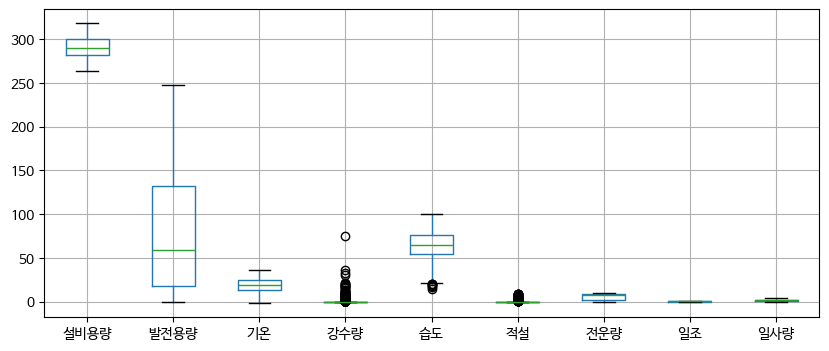

In [26]:
display(train_set[train_set.columns[1:]].describe())

plt.figure(figsize = (10, 4))
train_set[train_set.columns[1:]].boxplot()

print('''
Train 데이터로 기초 통계량을 확인해본 결과 강수량의 75% 0 최대값이 74로 이상치가 존재하는 것으로 보이지만,
단기간 폭우가 내일 수 있다는 점을 가만 한다면 이상치를 데이터에 포함하는 것이 필요해보인다. 이는
강수량의 최대값이 100인 내용과 맞 물리는 것으로 보이며, 강수량과 마찬가지로 적설도 이와 같은 맥락에서 해석된다면 (최대값 8.8)
발전용량의 최대값이 247인 점 (대비 75% 131)인 점과 같아보이며, 이상치 제거 없이 데이터를 구성하여 모델링을 진행한다.
''')

#### ✅ 2-3 train 데이터 세트의 발전량과 나머지 변수간의 상관관계

In [27]:
cor_df = train_set.drop(columns = ['일시','발전기명'],axis = 1)
cor_mat = cor_df.corr()['발전용량']
display(cor_mat.sort_values(ascending= True).to_frame().T)
print('''
발전용량과 전운량, 습도, 강수량, 적설, 설비용량은 음의 상관관계를 가지며,
기온, 일조와는 양의 상관관계를 가진다.
일사량과는 0.8의 강한 양의 상관관계를 가진다. 즉, 일사량이 많을 수록 발전용량이 함께 높게 나타나는 경향이 있으며
일사량과 발전량은 밀접한 연관성을 가지는 변수로 확인된다.
''')

,전운량,습도,강수량,적설,설비용량,기온,일조,일사량,발전용량
발전용량,-0.48449,-0.383281,-0.099701,-0.067622,-0.020767,0.11767,0.598131,0.857487,1.0



발전용량과 전운량, 습도, 강수량, 적설, 설비용량은 음의 상관관계를 가지며,
기온, 일조와는 양의 상관관계를 가진다.
일사량과는 0.8의 강한 양의 상관관계를 가진다. 즉, 일사량이 많을 수록 발전용량이 함께 높게 나타나는 경향이 있으며
일사량과 발전량은 밀접한 연관성을 가지는 변수로 확인된다.



#### ✅ 2-4 발전량을 종속변수로 하여 2개의 회귀모델링을 진행하고 모델을 평가

In [28]:
print('''
1) 랜덤 포레스트 회귀
여러 개의 결정 트리를 종합하여 수행하는 앙상블 모델로써
 - 이상치/노이즈에 강함
 - 여러 결정 트리의 예측의 평균을 나타내기 떄문에 과적합을 보완
 - 복잡한 비선형성 관계을 잘 예측하고, 별도의 스케일링 없이도 안정적인 성능을 발휘한다.

2) 선형회귀
선형회귀 분석은 독립변수와 종속변수의 선형적 관계를 가정하고 예측하는 기본 회귀 모델로,
  - 구현과 해석이 직관적이며, 설명력 있는 분석에 용이하다.
  - 상관 분석을 통해, 각 독립 변수가 발전용량과 음/양의 상관관계를 가지는 것으로 보아 적절한 모델로 선택한다.

''')


1) 랜덤 포레스트 회귀
여러 개의 결정 트리를 종합하여 수행하는 앙상블 모델로써
 - 이상치/노이즈에 강함
 - 여러 결정 트리의 예측의 평균을 나타내기 떄문에 과적합을 보완
 - 복잡한 비선형성 관계을 잘 예측하고, 별도의 스케일링 없이도 안정적인 성능을 발휘한다.

2) 선형회귀
선형회귀 분석은 독립변수와 종속변수의 선형적 관계를 가정하고 예측하는 기본 회귀 모델로,
  - 구현과 해석이 직관적이며, 설명력 있는 분석에 용이하다.
  - 상관 분석을 통해, 각 독립 변수가 발전용량과 음/양의 상관관계를 가지는 것으로 보아 적절한 모델로 선택한다.




In [29]:
#train_set
x_train = train_set.drop(columns = ['발전용량','일시','발전기명'])
y_train = train_set['발전용량']

#test_set
x_test = test_set.drop(columns = ['발전용량','일시','발전기명'])
y_test = test_set['발전용량']

In [30]:
#  x_train, x_test, y_train, y_test 주기
def eval_model(name, model , x_train, x_test, y_train, y_test) :
  if name == 'LR' :
    sx_train = pd.DataFrame(StandardScaler().fit_transform(x_train), columns = x_train.columns)
    sx_test = pd.DataFrame(StandardScaler().fit_transform(x_test), columns = x_test.columns)
    model.fit(sx_train, y_train)
    pred = model.predict(sx_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

  elif name =='RF' :
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred))

  return name, rmse


lst = []
for name, model in [['LR', LinearRegression()], ['RF',RandomForestRegressor()]] :
  model_name ,rmse  = eval_model(name, model , x_train, x_test, y_train, y_test)
  lst.append([model_name, rmse])

pd.DataFrame(lst, columns = ['Model_Name','RMSE'])

,Model_Name,RMSE
0,LR,39.614955
1,RF,35.319894


#### 📊 통계분석
#### ✅ 1.1 기본 회귀가정을 검토 : MEDV (집값): 종속변수

In [36]:
df = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_32회/data/32/adp32_s1.csv",index_col=0)
df = df.reset_index(drop = True)
df.head(3)

,ZN,INDUS,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT1,LSTAT2,MEDV
0,18.0,2.31,0.0,0.538,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,5.052,24.0
1,0.0,7.07,0.0,0.469,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,9.444,21.6
2,0.0,7.07,0.0,0.469,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,3.897,34.7


In [40]:
import statsmodels.api as sm

X = df.drop(columns = 'MEDV')
y = df['MEDV']

add_x = sm.add_constant(X)
model = sm.OLS(y, add_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     91.56
Date:                Fri, 04 Apr 2025   Prob (F-statistic):          4.27e-117
Time:                        05:40:48   Log-Likelihood:                -1543.7
No. Observations:                 506   AIC:                             3113.
Df Residuals:                     493   BIC:                             3168.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         68.6512      3.919     17.517      0.0


1.선형성 : 독립 변수와 종속변수는 선형관계를 가진다는 가정, 잔차 VS 예측값 
  - 에측값과 실제값이 대각선으로 분포하고 있는 것으로 보아, 독립변수와 종수변수간의 선형성 가정이 만족된것으로 확인된다. 

2.독립성 : 오차항들 간의 상관이 없다 
  -  잔차를 관측의 순서대로 나열한 그래프에서 특정 패턴이 없이 분포되어있는 것으로 보이지만, 
     더빈 왓슨 통계량이 1,243으로 2 기준으로 양의 상관을 가지며, 독립성을 완전히 만족하지 않는다. 

3.등분산성 : 오차의 분산이 일정해야한다는 가정
  - 심선 기준으로 퍼져있는 것으로 보이지만,몇몇 군대에서 흩어지는 부분이 보여지는 곳을 
    보여 등분산성에 완전하게 만족한 것은 아닌것으로 판단된다. 또한 Breusch-Pagan 검정의  p < 0.00001
    이는 등분산성 가정이 통계적으로 유의하게 위배된다는 것을 의미

4.정규성 : 오차항이 정규 분포를 따른다. 
  - QQ-plot 에서 잔차들이 대각선의 분포를 띄고 있지만, 꼬리부분에서 선이 벗어나는 경향을 보이고 있어, 
    부분적으로 만족한다고 볼 수 있다.  Shapiro-Wilk 검정의  p < 0.0000 정규분포를 따른다고 보기 어렵다



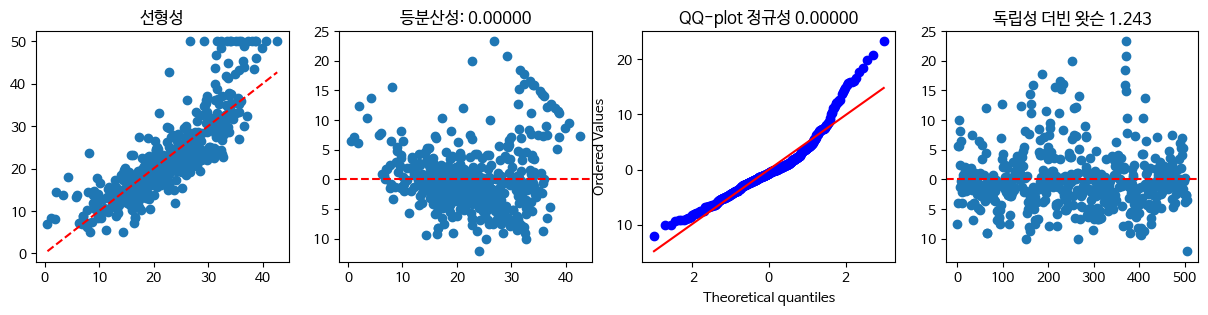

In [108]:
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro #정규
import statsmodels.stats.api as sms # 등분

print('''
1.선형성 : 독립 변수와 종속변수는 선형관계를 가진다는 가정, 잔차 VS 예측값
  - 에측값과 실제값이 대각선으로 분포하고 있는 것으로 보아, 독립변수와 종수변수간의 선형성 가정이 만족된것으로 확인된다.

2.독립성 : 오차항들 간의 상관이 없다
  -  잔차를 관측의 순서대로 나열한 그래프에서 특정 패턴이 없이 분포되어있는 것으로 보이지만,
     더빈 왓슨 통계량이 1,243으로 2 기준으로 양의 상관을 가지며, 독립성을 완전히 만족하지 않는다.

3.등분산성 : 오차의 분산이 일정해야한다는 가정
  - 심선 기준으로 퍼져있는 것으로 보이지만,몇몇 군대에서 흩어지는 부분이 보여지는 곳을
    보여 등분산성에 완전하게 만족한 것은 아닌것으로 판단된다. 또한 Breusch-Pagan 검정의  p < 0.00001
    이는 등분산성 가정이 통계적으로 유의하게 위배된다는 것을 의미

4.정규성 : 오차항이 정규 분포를 따른다.
  - QQ-plot 에서 잔차들이 대각선의 분포를 띄고 있지만, 꼬리부분에서 선이 벗어나는 경향을 보이고 있어,
    부분적으로 만족한다고 볼 수 있다.  Shapiro-Wilk 검정의  p < 0.0000 정규분포를 따른다고 보기 어렵다
''')

# 예측값
pred = model.predict(add_x)
# 잔차
resid = model.resid

fig, axes = plt.subplots(1,4 , figsize = (15,3))

# 선형성 : 예측값 VS 실제값
axes[0].scatter(pred, y)
axes[0].plot([min(pred), max(pred)],[min(pred), max(pred)], color = 'red', linestyle ='--')
axes[0].set_title("선형성")

# 등분산성 : 예측값 VS 잔차
axes[1].scatter(pred, resid)
axes[1].axhline(0, color = 'red', linestyle ='--')
stat, p_val, f_sta, pv = sms.het_breuschpagan(resid, model.model.exog)
axes[1].set_title(f"등분산성: {p_val:.5f}")

# 정규성
stats.probplot(resid, plot = axes[2])
stat, p_val = shapiro(resid)
axes[2].set_title(f"QQ-plot 정규성 {p_val:.5f}")

#독립성
axes[3].plot(resid.reset_index(drop =True), marker='o', linestyle='None') #Fixed the syntax error here
axes[3].axhline(0, color = 'red', linestyle ='--')
dw = durbin_watson(resid)
axes[3].set_title(f"독립성 더빈 왓슨 {round(dw, 3)}")
plt.show()

#### ✅ 1.2 변수간 관계 검토하고 문제점 해결방안 2가지를 제시

In [121]:
# 1. 상관관계 확인
# 2. 다중공선성 확인
# 목표) 변수들간의 관계 분석으로 중복된 정보를 제거하고, 모델의 안정성 및 해석력을 높힌다.

cor_mat = X.corr().unstack().reset_index()
cor_mat[(cor_mat['level_0'] != cor_mat['level_1']) & (np.abs(cor_mat[0]) >= 0.7)].drop_duplicates()

,level_0,level_1,0
15,INDUS,NOX,0.763651
17,INDUS,DIS,-0.708027
19,INDUS,TAX,0.720760
37,NOX,INDUS,0.763651
40,NOX,AGE,0.731470
41,NOX,DIS,-0.769230
51,AGE,NOX,0.731470
53,AGE,DIS,-0.747881
61,DIS,INDUS,-0.708027
63,DIS,NOX,-0.769230


In [126]:
# VIF
vif = pd.DataFrame()
vif['columns'] = X.columns

vif['VIF'] =[variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

print('''
1) 상관계수 : 다수의 컬럼들이 양/음의 강한 상관계를 가지고 있다.
2) 다중 공선성 : VIF > 10 이상일때 다중 공선성을 의심하는데, 10을 넘는 컬럼들이 매우 많다.

 해결방안 2가지를 제시
 1) 상관계수나 VIF 기준으로 문제가 되는 변수를 제거
 2) 주성분 분석 실행으로 다중 공선성 문제 완전 제거

VIF 결과에서 대부분의 컬럼들이 10 이상을 차지하기 때문에 PCA 주성분 분을 통해 차원을 축소하여, 다중 공선성을 제거하고
원래 변수의 분산을 주성분에 담아 유지 시킨다.
''')

    columns          VIF
0        ZN     2.653723
1     INDUS    13.947662
2      CHAS     1.147106
3       NOX    55.830870
4       AGE    20.451792
5       DIS    14.141537
6       RAD    14.103364
7       TAX    61.259305
8   PTRATIO    66.640449
9         B    19.453329
10   LSTAT1  1226.709156
11   LSTAT2  1225.661497

1) 상관계수 : 다수의 컬럼들이 양/음의 강한 상관계를 가지고 있다.
2) 다중 공선성 : VIF > 10 이상일때 다중 공선성을 의심하는데, 10을 넘는 컬럼들이 매우 많다.

 해결방안 2가지를 제시
 1) 상관계수나 VIF 기준으로 문제가 되는 변수를 제거
 2) 주성분 분석 실행으로 다중 공선성 문제 완전 제거 

VIF 결과에서 대부분의 컬럼들이 10 이상을 차지하기 때문에 PCA 주성분 분을 통해 차원을 축소하여, 다중 공선성을 제거하고
원래 변수의 분산을 주성분에 담아 유지 시킨다. 



In [138]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scaling
ss = StandardScaler()
s_x = pd.DataFrame(ss.fit_transform(X), columns = X.columns)

# 5개의 주성분으로 PCA 수행
pca = PCA(n_components= 4)
pca_x = pd.DataFrame(pca.fit_transform(s_x) , columns = ['PC_' + str(i) for i in range(pca.n_components_)] )
pca_x.head()


,PC_0,PC_1,PC_2,PC_3
0,-2.241594,0.913259,0.086831,-0.285784
1,-1.440880,0.562537,-0.923344,0.241369
2,-2.116026,0.543028,-0.324701,0.842866
3,-2.755498,0.023836,-0.298228,1.125730
4,-2.445442,0.036801,-0.573900,0.852807


#### ✅ 1.3 위 에서 제안한 것을 반영하여 문제를 해결하고 적용 결과를 제시

In [139]:
import statsmodels.api as sm

y = df['MEDV']

add_x = sm.add_constant(pca_x)
model = sm.OLS(y, add_x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     173.0
Date:                Fri, 04 Apr 2025   Prob (F-statistic):           5.93e-93
Time:                        07:11:03   Log-Likelihood:                -1620.7
No. Observations:                 506   AIC:                             3251.
Df Residuals:                     501   BIC:                             3273.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.5328      0.266     84.707      0.0

#### ✅ 1.4 cyl랑 gear 컬럼으로 교차테이블
#### ✅ 1.5 두 범주형 변수간 차이가 존재하는지 확인하려한다. 귀무가설과 대립가설을 작성

In [147]:
from scipy.stats import chi2_contingency

df = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_32회/data/32/adp32_s2.csv")

cross = pd.crosstab(df['cyl'], df['gear'])

stat, p_val, dof, expected = chi2_contingency(cross)
print(f'{stat:.3f} , {p_val:.3f}')

print('''
귀무 가설 : cyl과 gear는 독립이다. (상관이 없다)
대립 가설 : cyl과 gear는 독립이 아니다. (상관이 있다)

검정 통계량 18.036. p_val : 0.001 < 0.05 으로 귀무가설을 기각한다.
즉, cyl과 gear는 독립이 아니다. (상관이 있다)
''')

18.036 , 0.001

귀무 가설 : cyl과 gear는 독립이다. (상관이 없다)
대립 가설 : cyl과 gear는 독립이 아니다. (상관이 있다)

검정 통계량 18.036. p_val : 0.001 < 0.05 으로 귀무가설을 기각한다. 
즉, cyl과 gear는 독립이 아니다. (상관이 있다)



#### ✅ 1.6 각 성별의 급여 데이터가 정규성을 만족하는지 확인

In [153]:
df = pd.read_csv("/content/drive/MyDrive/ADP_SONY/ADP_32회/data/32/adp32_s3.csv")

#df['성별'].unique()

m = df[df['성별'] == '남']['급여']
f = df[df['성별'] == '여']['급여']

m_stat, m_p_val = shapiro(m)
f_stat, f_p_val = shapiro(f)

print(f'''
귀무 가설 : 정규성을 만족한다.
대립 가설 : 정규성을 만족하지 않는다.

남자의 경우 {m_p_val:.3f}  > 0.05 으로 정규성을 만족한다.
여자의 경우 {f_p_val:.3f}  < 0.05으로 정규성을 만족하지 않는다.

''')

 귀무 가설 : 정규성을 만족한다. 
           대립 가설 : 정규성을 만족하지 않는다. 
      남자의 경우 0.406  > 0.05 으로 정규성을 만족한다. 
      여자의 경우 0.000  < 0.05으로 정규성을 만족하지 않는다. 
      



#### ✅ 1.7 위 결과에 맞는 남녀 월급 차이가 있는지 확인 하기 위한 검정 전략

#### ✅ 1.8 가설에 따른 검정을 수행하고, 검정통계량과 p-value를 설명

In [155]:
print('''
여자의 경우 데이터가 정규성을 만족하지 않기 때문에 비모수 검정인 맨-휘트니 검정을 수행한다.
''')

from scipy.stats import mannwhitneyu

stat, p_val = mannwhitneyu(m,f)

print(f'''
귀무 가설 : 남녀 월급 차이가 있다.
대립 가설 : 남녀 월급 차이가 없다.

맨 휘트니 통계량의 p_value는 {p_val:.3f} < 0.05 남녀 월급 차이가 없다.
''')


여자의 경우 데이터가 정규성을 만족하지 않기 때문에 비모수 검정인 맨-휘트니 검정을 수행한다. 

 
귀무 가설 : 남녀 월급 차이가 있다. 
대립 가설 : 남녀 월급 차이가 없다. 

맨 휘트니 통계량의 p_value는 0.000 < 0.05 남녀 월급 차이가 없다. 

